In [76]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from sim_pipeline.galaxy_galaxy_lens_pop import GalaxyGalaxyLensPop
from sim_pipeline.Plots.galaxy_galaxy_plots import GalaxyGalaxyLensingPlots
from sim_pipeline.image_simulation import point_source_image_properties
from sim_pipeline.image_simulation import sharp_image, simulate_image
from sim_pipeline.Sources.source_variability.variability import sinusoidal_variability
from sim_pipeline.image_simulation import point_source_image
from sim_pipeline.Plots.plot_functions import create_image_montage_from_image_list
from sim_pipeline.Util.param_util import convolved_image
import lsst.daf.butler as dafButler
import lsst.geom as geom
import lsst.afw.display as afwDisplay
from astropy.table import Table
from sim_pipeline import lsst_science_pipeline

## Point source image simulation

This notebook shows how one can use sim-pipeline to simulate lensed images of point source and can add variability to them. For this, we should follow these steps:

1. Generate Point source lens population.
2. Select a random lens.
3. Extract psf kernels from a dp0 image or provide your own psf kernels
4. simulate point source image using information from point 3.

## Generate point source lens population

Here we use GalaxyGalaxyLensPop class to generate point source lens. 

In [4]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 23, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 26, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using GalaxyGalaxyLensPop
gg_lens_pop = GalaxyGalaxyLensPop(
    deflector_type="all-galaxies",
    source_type="quasars",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [48]:
kwargs_lens_cut={'min_image_separation': 0.8, 'max_image_separation': 10}
rgb_band_list=['i', 'r', 'g']
lens_class = gg_lens_pop.select_lens_at_random(**kwargs_lens_cut)

In [50]:
image_r = sharp_image(lens_class=lens_class, band=rgb_band_list[0], mag_zero_point=27, 
                      delta_pix=0.2, num_pix=101)

## Initiate Butler

In [54]:
config = "dp02"
collection = "2.2i/runs/DP0.2"
butler = dafButler.Butler(config, collections=collection)
skymap = butler.get("skyMap")

In [56]:
config = "dp02"
collection = "2.2i/runs/DP0.2"
butler = dafButler.Butler(config, collections=collection)
skymap = butler.get("skyMap")

# Near the center of DC2
ra = 62.541629  # degrees
dec = -37.852021  # degrees
point = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(101, 101)
# print(cutoutSize)


# Read this from the table we have at hand...
tractInfo = skymap.findTract(point)
patchInfo = tractInfo.findPatch(point)
my_tract = tractInfo.tract_id
my_patch = patchInfo.getSequentialIndex()

xy = geom.PointI(tractInfo.getWcs().skyToPixel(point))

bbox = geom.BoxI(xy + cutoutSize // 2, cutoutSize)

coaddId = {"tract": my_tract, "patch": my_patch, "band": "i"}
coadd = butler.get("deepCoadd", dataId=coaddId)
coadd_cut = butler.get("deepCoadd", parameters={"bbox": bbox}, dataId=coaddId)

## Extract psf of a dp0 image

In [59]:
psf_kernels = lsst_science_pipeline.cutout_image_psf_kernel(coadd_cut, lens_class, band='i', mag_zero_point=27, delta_pix=0.2, num_pix=101)

## Set a variability model from variability module

In [65]:
time = np.linspace(0, 50, 16)
variability = {'time': time, 
            'function': sinusoidal_variability}

In [66]:
convolved_deflector_image = convolve2d(
                image_r, psf_kernels['psf_kernel_for_deflector'][0])

# Simulate point source images

In [68]:
point_image = point_source_image(lens_class, band='i', mag_zero_point=27, delta_pix=0.2, num_pix=101, psf_kernels=psf_kernel_test['psf_kernel_for_images'][0], variability = variability)

/home/nkhadka/.local/lib/python3.11/site-packages/lenstronomy/Data/psf.py:80: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


In [69]:
final_images = []
for i in range(len(time)):
    final_images.append(point_image[0][i] + point_image[1][i] + convolved_deflector_image)

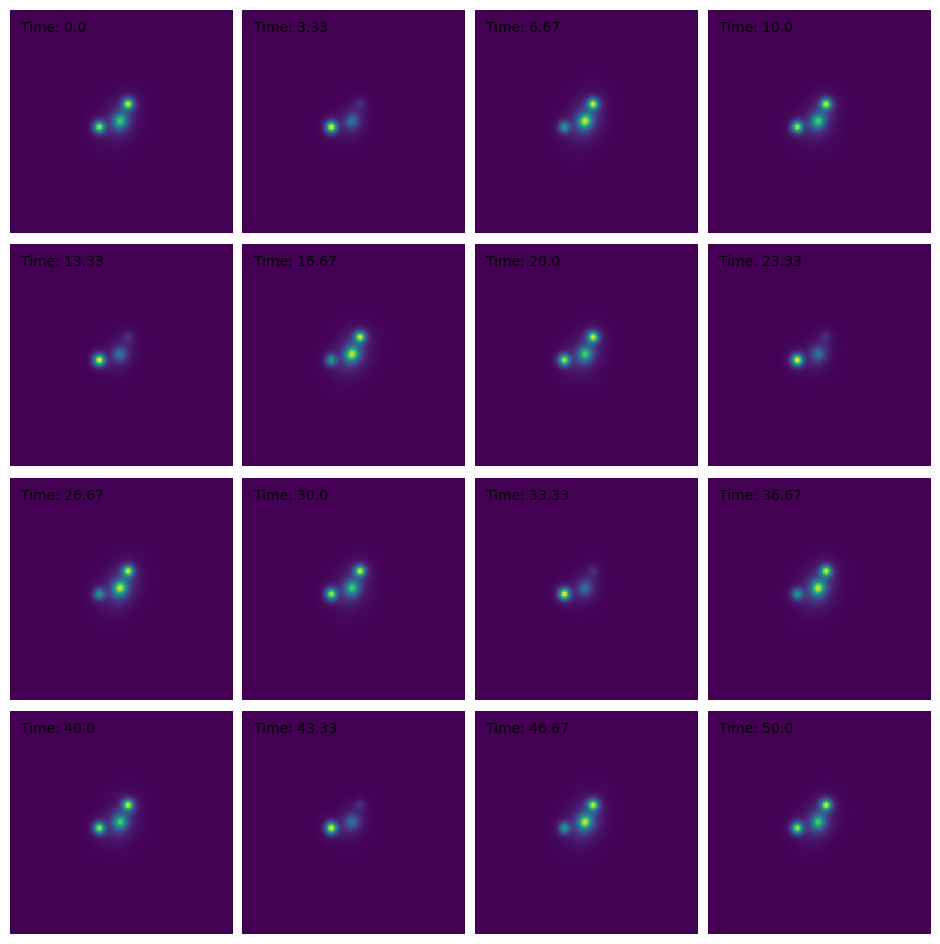

In [74]:
create_image_montage_from_image_list(num_rows=4, num_cols=4, images=final_images, time = time)